In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

SEEDS = 42

np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

C:\Users\sahar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_ds, validation_ds = tfds.load(
    "cifar10",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True,
)

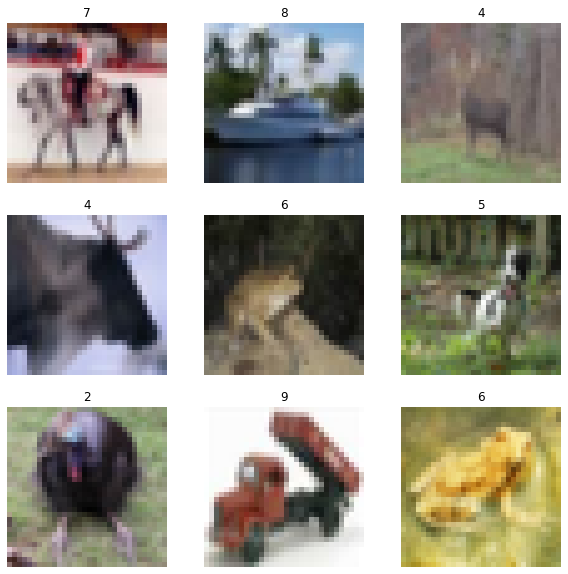

In [3]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")
RESIZE_TO = 384
CROP_TO = 224
BATCH_SIZE = 64
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
NUM_CLASSES = 10  # number of classes
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]  # more the dataset size the schedule length increase

In [4]:
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE


@tf.function
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    image = image / 255.0
    return (image, label)


@tf.function
def preprocess_test(image, label):
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = image / 255.0
    return (image, label)


DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)
repeat_count += 50 + 1  # To ensure at least there are 50 epochs of training

pipeline_train = (
    train_ds.shuffle(10000)
    .repeat(repeat_count)  # Repeat dataset_size / num_steps
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)


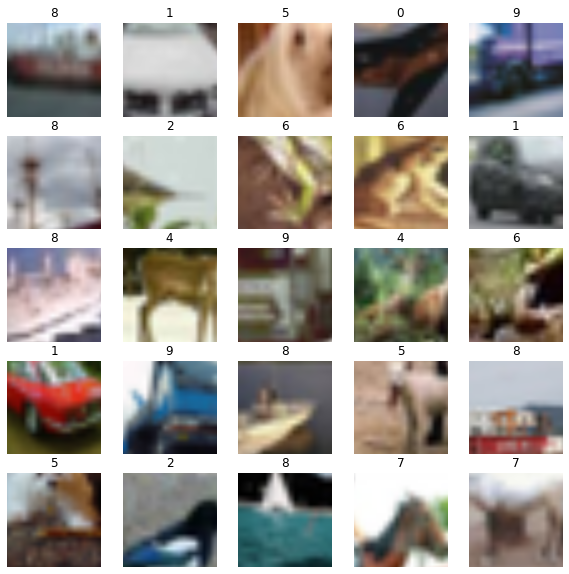

In [5]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")

In [6]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)
class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)


model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)
learning_rate = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [7]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=5, restore_best_weights=True
    )
]

In [8]:
history = model.fit(
    pipeline_train,
    batch_size=200,
    epochs=20,
    steps_per_epoch=50,
    validation_data=pipeline_validation,
    # callbacks=train_callbacks,
)

Epoch 1/20
50/50 [==============================] - 4335s 87s/step - loss: 1.0292 - accuracy: 0.6687 - val_loss: 0.5770 - val_accuracy: 0.8085
Epoch 2/20
50/50 [==============================] - 2629s 53s/step - loss: 0.6440 - accuracy: 0.7781 - val_loss: 0.5416 - val_accuracy: 0.8152
Epoch 3/20
50/50 [==============================] - 2415s 49s/step - loss: 0.5624 - accuracy: 0.8016 - val_loss: 0.4826 - val_accuracy: 0.8352
Epoch 4/20
50/50 [==============================] - 2270s 46s/step - loss: 0.5308 - accuracy: 0.8169 - val_loss: 0.4800 - val_accuracy: 0.8355
Epoch 5/20
50/50 [==============================] - 2234s 45s/step - loss: 0.5316 - accuracy: 0.8153 - val_loss: 0.4409 - val_accuracy: 0.8512
Epoch 6/20
50/50 [==============================] - 2363s 48s/step - loss: 0.5313 - accuracy: 0.8169 - val_loss: 0.4402 - val_accuracy: 0.8507
Epoch 7/20
50/50 [==============================] - 2662s 54s/step - loss: 0.5374 - accuracy: 0.8103 - val_loss: 0.4430 - val_accuracy: 0.8531

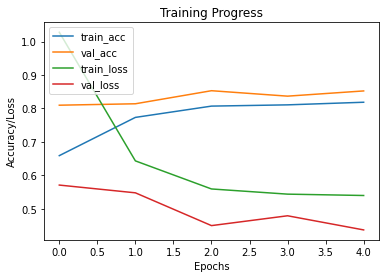

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

In [16]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

  4/118 [>.............................] - ETA: 1:07:16 - loss: 0.4405 - accuracy: 0.8516

In [ ]:
model.save("model4.tf")

INFO:tensorflow:Assets written to: model3.tf\assets


INFO:tensorflow:Assets written to: model3.tf\assets


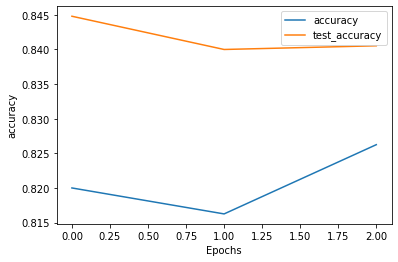

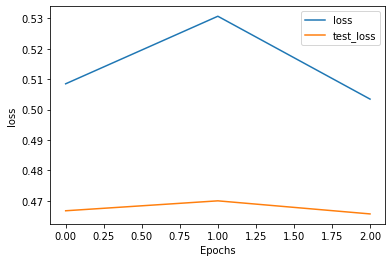

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'test_'+string])
  plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")